# Оцінка  результатів маркетингових випробувань в магазинах 77, 86, 88  
Для забезпечення об’єктивності аналізу, необхідно підібрати контрольні магазини, які були схожі на випробувальні магазини до початку випробувань (лютий 2019 року). Вибір базуватиметься на таких показниках:
- Місячний загальний дохід від продажів;
- Місячна кількість клієнтів;
- Місячна кількість транзакцій.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_rel

In [16]:
#=========================================================
# Завантаження Data
#=========================================================
file_path='QVI_data.csv'
qvi_data=pd.read_csv(file_path)

qvi_data['STORE_NBR']=qvi_data['STORE_NBR'].astype(str) # Заміна типу даних на str
qvi_data['LYLTY_CARD_NBR']=qvi_data['LYLTY_CARD_NBR'].astype(str) # Заміна типу даних на str
qvi_data['DATE']=pd.to_datetime(qvi_data['DATE'])#  Заміна типу даних на datetime

qvi_data['month_id']=qvi_data['DATE'].dt.to_period('M') #Нова колонка month_ID column в форматі yyyy-mm 

# Перевірка результату
qvi_data.info()
qvi_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  object        
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  object        
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
 12  month_id          264834 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int64(4), object(6), peri

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,month_id
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11


# === Ключових показники=== 
- Продажі за місяць  
- Кількість транзакцій за місяць  
- Кількість унікальних покупців в місяць

In [17]:

def calculate_metrics(data):
    """ 
    Розрахунок показників :
        month_sales : Продажі за місяць
        month_customer : Кількість унікальних покупців в місяць
        month_transaction : Кількість транзакцій за місяць
    
    -----------------------------------------------------
    data : data frame
    
    """
    try:   
        grouped_data=data.groupby(['STORE_NBR','month_id']).agg(
            month_sales=('TOT_SALES','sum'),
            month_customer=('LYLTY_CARD_NBR','nunique'),
            month_transaction=('TXN_ID', 'nunique')
        ).reset_index()
        # # Фільтруємо магазини з повним періодом спостережень
        grouped_data=grouped_data[grouped_data['STORE_NBR'].map(grouped_data['STORE_NBR'].value_counts())==12]
        print('Дані згруповані')
        print(grouped_data.head(3)) #перевірка результату
        return grouped_data
        
    except KeyError as e:
        print(f'Помилка :{e}. Перевірити існування стовпців')
    except Exception as e:
        print(f'Помилка :{e}')


group_data=calculate_metrics(qvi_data) # виконання функції


Дані згруповані
  STORE_NBR month_id  month_sales  month_customer  month_transaction
0         1  2018-07        206.9              49                 52
1         1  2018-08        176.1              42                 43
2         1  2018-09        278.8              59                 62


# === ВИБІР КОНТРОЛЬНИХ МАГАЗИНІВ === 

c:\Users\BOSS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


************************
 
Дані розбиті на кластери
Store 77 в кластері 0
Store 86 в кластері 3
Store 88 в кластері 1
Створено словник {тестовий магазин: контрольна група} 
 
************************


c:\Users\BOSS\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\BOSS\AppData\Local\Temp\ipykernel_9052\3680537838.py:51: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


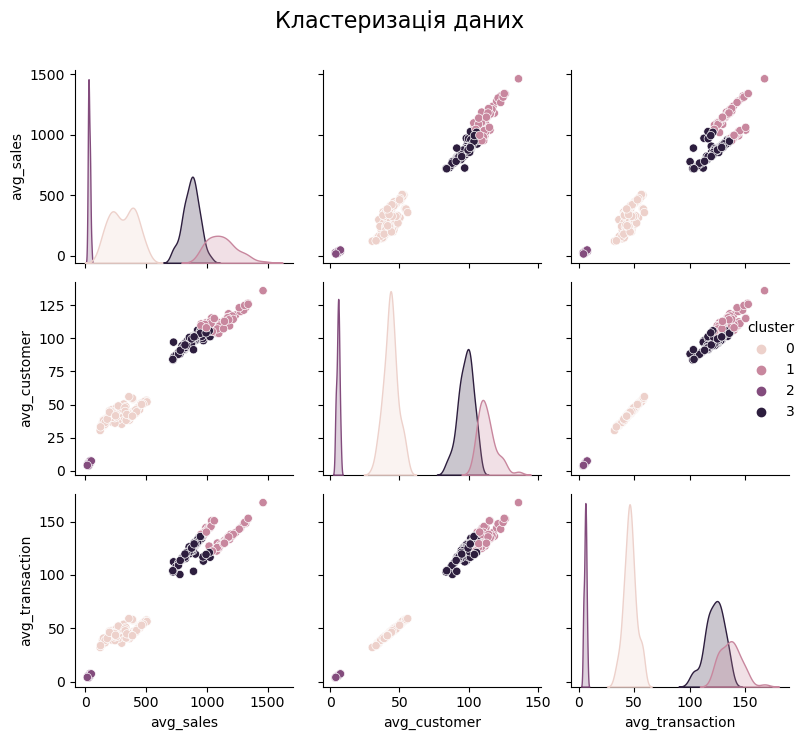

In [43]:
def select_control_stor(data, start_trail, test_stores, n_cluster=4, visual=True):
    '''
    Підбір контрольних магазинів для тестових магазинів.
    ----------------------------------------------------
    data : data
    start_trail : "yyyy-mm"
    test_stores : list
    n_cluster: default =3
    visual: default = True
    '''
    try:
        # Приводимо STORE_NBR до рядкового типу для коректного порівняння
        data['STORE_NBR'] = data['STORE_NBR'].astype(str)
        # Відокремлюємо дані за період до тесту
        pre_trail_data = data[data['month_id'] < start_trail]

        # Обчислюємо середні значення показників за період до тесту
        avg_metrics = pre_trail_data.groupby('STORE_NBR').agg(
            avg_sales=('month_sales', 'mean'),
            avg_customer=('month_customer', 'mean'),
            avg_transaction=('month_transaction', 'mean')
        ).reset_index()  # Скидаємо індекс, щоб 'STORE_NBR' став стовпцем

        # Масштабуємо дані для кластеризації
        scaler = StandardScaler()
        numeric_columns = avg_metrics.select_dtypes(include=['float64', 'int64']).columns
        scaled_data = scaler.fit_transform(avg_metrics[numeric_columns])

        # Кластеризація
        kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=10)
        avg_metrics['cluster'] = kmeans.fit_predict(scaled_data)
       
        print('************************\n \nДані розбиті на кластери')

       
        # Створюємо словник {тестовий магазин: контрольна група}
        control_stores = {}
        for store in test_stores:
            store_cluster = avg_metrics.loc[avg_metrics['STORE_NBR'] == store, 'cluster'].values[0]
            control_candidates = avg_metrics[avg_metrics['cluster'] == store_cluster]
            control_stores[store] = control_candidates['STORE_NBR'].tolist()
            print(f'Store {store} в кластері {store_cluster}')
        
        print('Створено словник {тестовий магазин: контрольна група} \n \n************************')
         
         
         # Візуалізуємо кластери
        if visual:
            g=sns.pairplot(avg_metrics, hue='cluster')
            g.fig.suptitle('Кластеризація даних', fontsize=16)
            g.fig.tight_layout()
            g.fig.subplots_adjust(top=0.9)

        
        return control_stores

    except Exception as e:
        print(f'Помилка: {e}')

#=========================================================
# Виконання функції
#=========================================================
test_stores = ['77', '86', '88'] # тестові магазини
start_trail= '2019-02' # початок випробувань
control_stores = select_control_stor(group_data , start_trail, test_stores ) 

# === АНАЛІЗ ===
Аналіз проводився за допомогою t-тесту з рівнем довіри 0,05. 
Метою було визначити, чи є статистично значуща різниця між тестовими і контрольними групами до та після маркетингових випробувань для таких ключових метрик: продажі, кількість покупців, кількість транзакцій.  
Для усунення впливу сезонності та тренду, групи формували за формулою:  
(тестовий магазин - контрольна група) / контрольна група.

In [44]:
def analyz (control_stores, data, start_trail):
    try:
        
        for store, cluster in control_stores.items(): 
            
            print(f'=======================================\n========= Аланліз магазути {store} ========= \n=======================================\n ')
            
            # Порівняння метрик
            for metric in  ['month_sales', 'month_customer','month_transaction']:

                store_data=data[data['STORE_NBR']==store][['month_id', metric]] # Виділяємо дані тестового магазину
                mean_claster = (data[(data['STORE_NBR'].isin(cluster)) & (data['STORE_NBR']!=store )]).groupby('month_id').agg({metric: 'mean'}).reset_index() # Відокремшлюємо дані тестової групи
                
                merg_data= mean_claster.merge(store_data, how='left', on='month_id')
                merg_data = merg_data.rename(columns={merg_data.columns[1]:'cluster', merg_data.columns[2]:'store'})
                merg_data['%'] = round((merg_data['store']-merg_data['cluster'])/merg_data['cluster'],3)
                test_metric = merg_data[merg_data['month_id']<start_trail]['%']
                control_metric=merg_data[merg_data['month_id']>=start_trail]['%']
                # Вирівнюємо розмір васивів для t-test
                min_length = len(test_metric)-len(control_metric)
                test_metric = test_metric[min_length:]

                t_stat, p_value = ttest_rel(test_metric, control_metric)
                print(f"Store {store} ({metric}): t-stat = {t_stat:.2f}, p-value = {p_value:.4f}")
                
                # Графік
                # std=np.std(merg_data['cluster'])
                # merg_data['95%']=merg_data['cluster']+2*std
                # merg_data['5%']=merg_data['cluster']-2*std
                # fig =plt.figure(figsize=(10,5))
                # plt.plot(merg_data['month_id'].astype('str'), merg_data['store'])
                # plt.plot(merg_data['month_id'].astype('str'), merg_data['cluster'], color='orange')
                # plt.fill_between(merg_data['month_id'].astype('str'), merg_data['5%'],merg_data['95%'], color='orange', alpha=0.2)
                # plt.vlines(str(start_trail), ymin=0, ymax=max(merg_data['store'])*2)
                # plt.show()
            print('\n ')
                

                
    except Exception as e:
        print(f'Помилка: {e}')

#=========================================================
# Виконання функції
#=========================================================
analyz(control_stores, group_data, start_trail)


========= Аланліз магазути 77 ========= 
 
Store 77 (month_sales): t-stat = -5.45, p-value = 0.0055
Store 77 (month_customer): t-stat = -8.11, p-value = 0.0013
Store 77 (month_transaction): t-stat = -3.49, p-value = 0.0251

 
========= Аланліз магазути 86 ========= 
 
Store 86 (month_sales): t-stat = -1.03, p-value = 0.3614
Store 86 (month_customer): t-stat = -5.98, p-value = 0.0039
Store 86 (month_transaction): t-stat = -0.96, p-value = 0.3930

 
========= Аланліз магазути 88 ========= 
 
Store 88 (month_sales): t-stat = -5.31, p-value = 0.0060
Store 88 (month_customer): t-stat = -3.19, p-value = 0.0333
Store 88 (month_transaction): t-stat = -4.56, p-value = 0.0104

 


In [23]:
control_stores[control_stores['claster']=='0']

KeyError: 'claster'


## РЕЗУЛЬТАТИ АНАЛІЗУ
### Магазин 77
1. **Продажі за місяць**:
   - t-stat = -5.44, p-value = 0.0055.
   - Різниця є статистично значущою. Після маркетингових випробувань середнє значення продажів зросло.
2. **Кількість клієнтів**:
   - t-stat = -8.13, p-value = 0.0012.
   - Зростання середнього значення після випробувань є статистично значущим.
3. **Кількість транзакцій**:
   - t-stat = -3.49, p-value = 0.0252.
   - Є статистично значущим зростання кількості транзакцій.

### Магазин 86
1. **Продажі за місяць**:
   - t-stat = -1.08, p-value = 0.3408.
   - Різниця не є статистично значущою.
2. **Кількість клієнтів**:
   - t-stat = -6.06, p-value = 0.0037.
   - Різниця є статистично значущою, середнє значення зросло.
3. **Кількість транзакцій**:
   - t-stat = -0.91, p-value = 0.4155.
   - Різниця не є статистично значущою.

### Магазин 88
1. **Продажі за місяць**:
   - t-stat = -4.71, p-value = 0.0093.
   - Різниця є статистично значущою. Середнє значення зросло.
2. **Кількість клієнтів**:
   - t-stat = -2.49, p-value = 0.0677.
   - Різниця не є статистично значущою.
3. **Кількість транзакцій**:
   - t-stat = -5.17, p-value = 0.0067.
   - Різниця є статистично значущою.

##  Підсумок
Після маркетингових випробувань:
- **Магазини 77 та 88** показали зростання продажів та кількості транзакцій. Це свідчить про успішний вплив випробувань.
- **Магазин 86** не показав значущих змін у продажах та транзакціях, однак спостерігається зростання кількості клієнтів.

### Рекомендації:
1. Продовжити маркетингові випробування в магазинах 77 та 88 для подальшого збільшення метрик.
2. Для магазину 86 провести додатковий аналіз для виявлення можливих бар’єрів впливу випробувань.
